In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime as dt

In [31]:
def plot_scenarios(df1, df2, df_median, dfdata,
                   country1, country2, data_SUS= False, fit_until= '05-13', 
                   error1= True, error2= True, errorm= False, 
                   SUS= False, ylim= 10000, capacity= 5017, file_s= 'state_SP', Z= 1., save= False, pdf= False):

    if SUS:
        file_s = file_s + '_SUS'
        n_mean = 'n_mean_ICU_SUS'
        n_std  = 'n_std_ICU_SUS'
        median = 'median_SUS'
        std = 'std_SUS'
        y_label = 'Number of ICU beds (SUS)'
        plot_data = False

    else:
        n_mean = 'n_mean_ICU'
        n_std  = 'n_std_ICU'
        median = 'median'
        std = 'std'
        y_label = 'Number of ICU beds'
        plot_data = True
        
        
    today = pd.to_datetime('2020-' + fit_until) + timedelta(days=1)

    fig, ax = plt.subplots()

    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    dfdata.index = pd.to_datetime(dfdata.index)

    ############################################################################
    ###### SUBNOTIFICATION FACTOR

    if data_SUS:
        n_mean_opt = 'n_mean_ICU_SUS'
        fitted = 'fitted with SUS data'
    else:
        n_mean_opt = 'n_mean_ICU'
        fitted = 'fitted with non-SUS data'

    df1_data = df1.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]
    df2_data = df2.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]
    dfdata_data = dfdata.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]

    def error_(x):
        median = np.median([df1_data[n_mean_opt ], df2_data[n_mean_opt]], axis=0)
        error = ((dfdata_data['n_data_ICU'] - x*median)**2).sum()
        return error


    sub = minimize(error_, x0=10).x[0]

    ###############################
    ######## MEDIAN

    ax = (sub*df_median[median][today:]).plot(color= 'gold', label= 'Median', linewidth= 2.5)

    if errorm:
        ax.fill_between(df_median[today:].index,
                        sub*(df_median[median][today:] - Z*df_median[std][today:]),
                        sub*(df_median[median][today:] + Z*df_median[std][today:]),
                        alpha= 0.3, color= 'gold')

    ymaxm   = sub*(df_median.loc[df_median[median].idxmax()].loc[median])
    yerrorm = Z*df_median.loc[df_median[median].idxmax()].loc[std] * sub

    if capacity > 0:
        colapse_m = df_median[ sub*df_median[median] > capacity ].index.tolist()
        if len(colapse_m) > 0:
            colapse_datem = colapse_m[0].strftime('%Y-%m-%d')
        else:
            colapse_datem = 'no colapse'
    else:
        colapse_datem = 'capacity not informed'

    
    ############################################################################
    ###### DATA
    if plot_data:
        ax = dfdata['n_data_ICU'].plot(marker= 'o', color= 'C1', label= 'Data')

    ############################################################################
    ###### AFTER TODAY
    ax = (sub*df1[n_mean][today:]).plot(label= country1, color= 'C3')

    if error1:
        ax.fill_between(df1[today:].index,
                        sub*(df1[n_mean][today:] - Z*df1[n_std][today:]),
                        sub*(df1[n_mean][today:] + Z*df1[n_std][today:]),
                        alpha= 0.3, color= 'C3')

    ymax1   =  df1.loc[df1[n_mean].idxmax()].loc[n_mean] * sub
    yerror1 = Z*df1.loc[df1[n_mean].idxmax()].loc[n_std] * sub

    if capacity > 0:
        colapse_1 = df1[ sub*df1[n_mean] > capacity ].index.tolist()
        if len(colapse_1) > 0:
            colapse_date1 = colapse_1[0].strftime('%Y-%m-%d')
        else:
            colapse_date1 = 'no colapse'
    else:
        colapse_date1 = 'capacity not informed'

    ############################################################################
    ax = (sub*df2[n_mean][today:]).plot(label= country2, color= 'C2')

    if error2:
        ax.fill_between(df2[today:].index,
                        sub*(df2[n_mean][today:] - Z*df2[n_std][today:]),
                        sub*(df2[n_mean][today:] + Z*df2[n_std][today:]),
                        alpha= 0.3, color= 'C2')

    ymax2   = df2.loc[df2[n_mean].idxmax()].loc[n_mean] * sub
    yerror2 = Z*df2.loc[df2[n_mean].idxmax()].loc[n_std] * sub

    if capacity > 0:
        colapse_2 = df2[ sub*df2[n_mean] > capacity ].index.tolist()
        if len(colapse_2) > 0:
            colapse_date2 = colapse_2[0].strftime('%Y-%m-%d')
        else:
            colapse_date2 = 'no colapse'
    else:
        colapse_date2 = 'capacity not informed'

    ############################################################################
    ###### BEFORE TODAY
    ax = (sub*df1[n_mean][:today]).plot(color= 'C7', label='_nolegend_')

    ax.fill_between(df1[:today].index,
                    sub*(df1[n_mean][:today] - Z*df1[n_std][:today]),
                    sub*(df1[n_mean][:today] + Z*df1[n_std][:today]),
                    alpha= 0.3, color= 'gray')



    ############################################################################
    ax = (sub*df2[n_mean][:today]).plot(color= 'C7', label='_nolegend_')

    ax.fill_between(df2[:today].index,
                    sub*(df2[n_mean][:today] - Z*df2[n_std][:today]),
                    sub*(df2[n_mean][:today] + Z*df2[n_std][:today]),
                    alpha= 0.3, color= 'gray')

    ax.set_ylabel(y_label,fontsize= 14)
    ax.set_xlabel('Date', fontsize= 14)
    ax.set_ylim([0, ylim])

    if capacity > 0:
        ax.axhline(y= capacity, color= 'C0', label= 'Capacity', linestyle= ':', linewidth= 2.0)

    ############################################################################
    l_inf1 = sub*(df1[n_mean] - Z*df1[n_std])
    l_sup1 = sub*(df1[n_mean] + Z*df1[n_std])

    colapse_int1_ = df1[ ( capacity >= l_inf1 ) & ( capacity <= l_sup1)].index
    colapse_int1 = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_int1_]

    l_inf2 = sub*(df2[n_mean] - Z*df2[n_std])
    l_sup2 = sub*(df2[n_mean] + Z*df2[n_std])

    colapse_int2_ = df2[ ( capacity >= l_inf2 ) & ( capacity <= l_sup2)].index
    colapse_int2 = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_int2_]

    l_infm = sub*(df_median[median] - Z*df_median[std])
    l_supm = sub*(df_median[median] + Z*df_median[std])

    colapse_intm_ = df_median[ ( capacity >= l_infm ) & ( capacity <= l_supm)].index
    colapse_intm = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_intm_]
    ############################################################################
    
    ax.legend(loc= 'upper left')

    filename = 'results/figures/FIGURE_ICU_' + file_s

    if save:
        f = open(filename + '.txt', 'w')
        f.write(file_s + '\n')
        f.write(country1 + ' --- max: ' + str(ymax1) + ' +- ' + str(yerror1) + ' date: ' + df1[n_mean].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' +                      colapse_date1 + '\n')
        f.write(country2 + ' --- max: ' + str(ymax2) + ' +- ' + str(yerror2) + ' date: ' + df2[n_mean].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' +                      colapse_date2 +  '\n')
        f.write('median' + ' --- max: ' + str(ymaxm) + ' +- ' + str(yerrorm) + ' date: ' + df_median[median].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' + 
                colapse_datem + '\n')
        f.write('sub factor = ' + str(sub) + ' --- ' + fitted + '\n')
        f.write('scenarios fitted with ' + file_s + ' data until: ' + fit_until + '\n')
        f.write('-----------' + '\n')
        f.write(country1 + ' --- colapse interval: ' + str(colapse_int1) + '\n')
        f.write('-----' + '\n')
        f.write(country2 + ' --- colapse interval: ' + str(colapse_int2) + '\n')
        f.write('-----' + '\n')
        f.write('median' + ' --- colapse interval: ' + str(colapse_intm) + '\n')
        f.close()

        if pdf:
            plt.savefig(filename + '.pdf', bbox_inches='tight')
        else:
            plt.savefig(filename + '.png', bbox_inches='tight')

    plt.show()

In [29]:
fit_until = '05-13'
t0 = 45

state_or_city = 'state'
#state_or_city = 'city'

name = 'SP'
#name = 'interior_SP'
#name = 'grande_SP'

country1 = 'Spain'
country2 = 'Germany'
#country2 = 'Switzerland'

In [19]:
file1 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country1 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
file2 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country2 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'

if name == 'SP':
    file3 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + 'MEDIAN' + '_t0=' + str(t0) + '_fit_until_' + fit_until + '_' + country1 + '_' + country2 + '.pkl'
else:
    file3 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + 'MEDIAN' + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'


df1_ICU = pd.read_pickle(file1) 
df2_ICU = pd.read_pickle(file2) 
df_median = pd.read_pickle(file3)

In [32]:
df_ICU_data = pd.DataFrame(columns= ['date', 'n_data_ICU'])
df_ICU_data['date'] = df1_ICU.index
df_ICU_data = df_ICU_data.set_index(['date'])

df_ICU_data.loc['2020-05-08', 'n_data_ICU'] = 3474
df_ICU_data.loc['2020-05-04', 'n_data_ICU'] = 3534
df_ICU_data.loc['2020-04-29', 'n_data_ICU'] = 2088
df_ICU_data.loc['2020-04-25', 'n_data_ICU'] = 2906
df_ICU_data.loc['2020-04-23', 'n_data_ICU'] = 2807
df_ICU_data.loc['2020-04-20', 'n_data_ICU'] = 2345
df_ICU_data.loc['2020-04-17', 'n_data_ICU'] = 2275
df_ICU_data.loc['2020-04-15', 'n_data_ICU'] = 1143
df_ICU_data.loc['2020-04-14', 'n_data_ICU'] = 1042

today =  2020-05-14 00:00:00


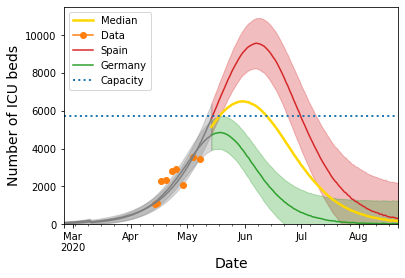

In [35]:
plot_scenarios(df1= df1_ICU, df2= df2_ICU, df_median= df_median, dfdata= df_ICU_data,
               country1= country1, country2= country2, data_SUS= False, fit_until= fit_until,
               error1= True, error2= True, errorm= False, 
               SUS= False, ylim= 11500, capacity= 5700,  file_s= 'state_SP',
               Z= 1, save= False, pdf= False)